**K-Nearest Nighbour Classifier**

In this code, we implement one nearest neighbour classifier on CIFAR-10 Dataset and calculate its efficiency.

https://www.cs.toronto.edu/~kriz/cifar.html



In [1]:
import pickle
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from random import random
from sklearn.model_selection import train_test_split
import pandas as pd

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

datadict_tst = unpickle(r'cifar-10\test_batch') #Loads all unpickled raw Test data in datadict_tst variable

labeldict = unpickle(r'cifar-10\batches.meta')
label_names = labeldict["label_names"]

def Load_Data(Data_sets):
    LBL=[]
    for i in range(1, Data_sets+1):

        path='cifar-10\data_batch_{}'.format(i)
        Load = unpickle(r'{}'.format(path))
        DAT=Load["data"]           
        LBL+=Load["labels"]
        if i == 1:           
            Da=Load["data"]           
        else:
            Da=np.vstack([Da, DAT])           
#    print("Data Shape:",Da.shape)
    LBL = np.array(LBL)
#    print("Label Shape:",LBL.shape)
    return Da,LBL


X,Y=Load_Data(5) #Load All 5 data sets into X1 and Labels in Y
X = X.astype("int32") #Reshape the 10K images into 3072. (Flattened)

Q1a = datadict_tst["data"]
Q_Label = datadict_tst["labels"]

Q_TST = Q1a.astype("int32") #Reshape the 10K images into 3072. (for RGBs)  
Q_Label = np.array(Q_Label)  ## contains class numbers for each image to tell which img belongs to which class

print('All Datasets Loaded')
print("Dataset's Dimensions:" ,X.shape)
print("Test Dataset's Dimensions:" ,Q_TST.shape)

print('========================================================================')



All Datasets Loaded
Dataset's Dimensions: (50000, 3072)
Test Dataset's Dimensions: (10000, 3072)


The Information in **X[0]** is given as a single vector of 3072. The color information is encoded as all reds together, all greens together and all blues together. so, 3 images of red,green,blue (3,32,32), we transpose it and re-arrange the channels to get correct image in order of (32,32,3)

Shape before:  (3072,)
Shape after:  (32, 32, 3)


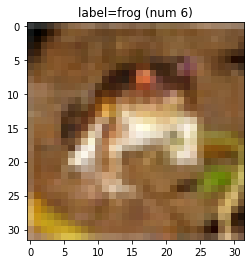

In [2]:
lbl=Y[0]
print("Shape before: ", X[0].shape)
img=X[0].reshape(3,32,32).transpose(1,2,0)  #0 - channels at last, 1 - 32 width first, 2 - 32 height second, total (32,32,3)
print("Shape after: ", img.shape)
plt.title(f"label={label_names[lbl]} (num {lbl})")
plt.imshow(img)

Define Random classifier and accuracy calculation function.

Random classifier will randomly try to guess the classes of the test dataset. Considering we have 10 classes, the random classifier has at best 10% chance of correctly classifying the images. So, anything we build has to be better than 10% baseline to be considered as better.

In [3]:
def class_acc(pred,gt): #This function will compare the Labels that were predicted using any 
                        #classifier (such as Random or 1NN) to Original labels that came with dataset (our ground truth)
                        #and will give us an accuracy estimate of our program.
    err=0            #will store number of mismatches
    accuracy=0          #wil be used to calculate accuracy
    for i in range(0,len(gt)): #Loop to iterate through all ground truth variables and compare with pred.
        if gt[i]!=pred[i]:     #comparing each Pred label to gt label
            err=err+1;         #increment the error counter

    accuracy=(len(pred)-err)/(len(pred)) #calculate the accuracy ((totalpts-error)/totalpts)*100(for %)
    accuracyPercentage=accuracy*100
    return accuracyPercentage

def cifar10_classifier_random(x): #This function will generate random label values from 0 to 9 for the given dataset.
    Rand_labels=np.array([])
    #print("=========== CALLING FUNC. cifar10_classifier_random Random Labels generator ===========")
    
    for i in range(0,len(x)): #Runs a loop from 0 to the length of your dataset
        Rand_label_val=randint(0, 9) #generates a list of random labels for that dataset. 
        Rand_labels = np.append(Rand_labels,Rand_label_val)
        
    #print("Predicted Label's Dimensions: ",Rand_labels.shape) #verify the shape of predicted labels
    return Rand_labels                                      #return predicted variables.


print("accuracy and Random functions Loaded...")

accuracy and Random functions Loaded...


**Random Classifier Accuracy**

In [4]:
Values=cifar10_classifier_random(X)  #Function predicts and returns an array full of Random Labels.
Acc=class_acc(Values,Y) #Function Evaluates the Predicted labels and Actual labels to calculate the Accuracy %.
print("Random Classifier Accuracy for Predicted Labels in %: ",Acc)

Random Classifier Accuracy for Predicted Labels in %:  10.298


KNN function will compare the query each datapoint with each datapoint in our database(X) and find the top K closest matches. Distances are sorted in ascending order and top-K are taken. Then we find the ones that are unique and their frequency. Return the Label which shows the highest frequency of occurance. 

In [5]:
def dist(A,B):                               #manual Euclidean method (not used to increase the speed of exec.)
    return np.sqrt(np.sum(np.square(A-B) ))  #query pt. array - data pt. array #takes 1.4 sec per image on 50k dataset

def dist1(A,B):
    return np.sqrt( np.sum( (A**2) - (2*A*B) + (B**2) ) )  #Slow, takes avg. 2.48 sec per image on 50k dataset



def batch_KNN(Xa,Ya,Qa,K): #Xa array carries dataset Ya array carries matching label values for Xa array, 
                           #Qa is the array; K is how many nearest neighbours to consider before deciding the class.
    
    #print("=========== Batch_KNN Classifier K={} ===========".format(K))
    #print("Query Dataset's Shape is: ",Qa.shape) #verify the shape of Qa TEST dataset
    
    KNN_labels=np.array([])
    for i in range(0,len(Qa)): #Runs a loop from 0 to the length of your TEST dataset

        OP = KNN(Xa,Ya,Qa[i],K) #Run function KNN to calculate the values of Predicted Labels
        KNN_labels = np.append(KNN_labels,OP)
        
    return KNN_labels                                      #return predicted variables.   



def KNN(Xp,Yp,Qp,K):  #Xp array carries data pts Yp array carries matching label values for Xp array, Qp is test point to match
    
    m = Xp.shape[0]  #to check how many data pts we have
    dist_values = []
    
    for i in range(m): #run as many times as data pts in Xp array
        dst = dist(Qp,Xp[i]) #call function to calc. dist b/w Qp and Xp[i]th object in array
        dist_values.append((dst,Yp[i])) #add distance and mark with Yp array (containing labels)
    
    dist_values2 = sorted(dist_values,key = lambda x:x[0])[:K] #sort distances from smallest to largest, save first K values
    dist_values2=np.array(dist_values2)                        #Convert to array
    dist_values3=np.unique(dist_values2[:,1],return_counts=True)  #return the frequencies of labels in K distances. 
                                                                  #(which class occurs howmany times...)
    index=dist_values3[1].argmax()                                #Get the index of ones which occurs maximum number of times.
    output=dist_values3[0][index]                                 #Get that class Label value.
    
    return output

print("KNN Function Loaded...")

KNN Function Loaded...


**Testing the speed of Algo**

**Regular Batch KNN**

In [12]:
X_small, aa, Y_small, bb = train_test_split(X, Y, test_size=44000, random_state=0, stratify=Y)
print("Small Dataset's Dimensions:" ,X_small.shape,"class Dim: ", Y_small.shape)

Q_TST_small, cc, Q_Label_small, dd = train_test_split(Q_TST, Q_Label, test_size=8000, random_state=0, stratify=Q_Label)
print("Small Test Dataset's Dimensions:" ,Q_TST_small.shape,"class Dim: ", Q_Label_small.shape)


Small Dataset's Dimensions: (6000, 3072) class Dim:  (6000,)
Small Test Dataset's Dimensions: (2000, 3072) class Dim:  (2000,)


In [13]:
%%timeit -r 1 -n 2
k=1
BATCH = batch_KNN(X_small, Y_small, Q_TST_small, k)
BATCH_Acc = class_acc(BATCH,Q_Label_small)
print("K={} Accuracy in %: ".format(k), BATCH_Acc)

K=1 Accuracy in %:  28.050000000000004
K=1 Accuracy in %:  28.050000000000004
3min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 2 loops each)


### K Nearest Neighbour Classifier

**Let's run on a smaller batch for multiple K values.**

First, let's create a smaller datasets using traintest split with equal class distributions.

In [7]:
X_small, aa, Y_small, bb = train_test_split(X, Y, test_size=44000, random_state=0, stratify=Y)
print("Small Dataset's Dimensions:" ,X_small.shape,"class Dim: ", Y_small.shape)

Q_TST_small, cc, Q_Label_small, dd = train_test_split(Q_TST, Q_Label, test_size=8000, random_state=0, stratify=Q_Label)
print("Small Test Dataset's Dimensions:" ,Q_TST_small.shape,"class Dim: ", Q_Label_small.shape)

Small Dataset's Dimensions: (6000, 3072) class Dim:  (6000,)
Small Test Dataset's Dimensions: (2000, 3072) class Dim:  (2000,)


**let's verify their distributions...**

In [8]:
print("Small Training dataset...")
df_Y_Full_New = pd.DataFrame(Y_small)
print(df_Y_Full_New.value_counts(sort=True))
print()
print("Total datapoints" , Y_small.shape[0])
print()
print()
print("Small Test dataset...")
df_Y_Full_New = pd.DataFrame(Q_Label_small)
print(df_Y_Full_New.value_counts(sort=True))
print()
print("Total datapoints" , Q_Label_small.shape[0])

Small Training dataset...
0    600
1    600
2    600
3    600
4    600
5    600
6    600
7    600
8    600
9    600
dtype: int64

Total datapoints 6000


Small Test dataset...
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
dtype: int64

Total datapoints 2000


In [9]:
Accuracy_List=[]

for k in range (1,16):
    
    BATCH = batch_KNN(X_small, Y_small, Q_TST_small, k)
    BATCH_Acc = class_acc(BATCH,Q_Label_small)
    Accuracy_List.append(BATCH_Acc)
    print("K={} Accuracy in %: ".format(k), BATCH_Acc)

K=1 Accuracy in %:  28.050000000000004
K=2 Accuracy in %:  24.55
K=3 Accuracy in %:  26.150000000000002
K=4 Accuracy in %:  26.85
K=5 Accuracy in %:  28.449999999999996
K=6 Accuracy in %:  28.9
K=7 Accuracy in %:  27.700000000000003
K=8 Accuracy in %:  28.749999999999996
K=9 Accuracy in %:  28.4
K=10 Accuracy in %:  28.799999999999997
K=11 Accuracy in %:  28.299999999999997
K=12 Accuracy in %:  28.000000000000004
K=13 Accuracy in %:  28.4
K=14 Accuracy in %:  28.65
K=15 Accuracy in %:  28.000000000000004


**Plot the accuracy data over Multiple K values**

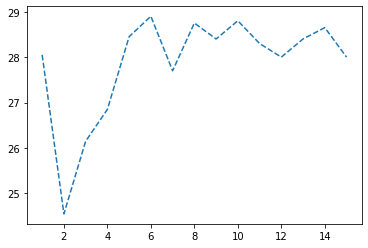

In [10]:
K_values = np.arange(1,len(Accuracy_List)+1)
plt.figure()
plt.plot(K_values,Accuracy_List,'--')
plt.show()